In [17]:
import os
import psycopg2
import pandas as pd

# --- Conexión a PostgreSQL ---
conn = psycopg2.connect(
    host=os.getenv("PG_HOST"),
    port=os.getenv("PG_PORT"),
    database=os.getenv("PG_DB"),
    user=os.getenv("PG_USER"),
    password=os.getenv("PG_PASSWORD")
)
cur = conn.cursor()
print("Conectado correctamente a la base de datos.")

# --- Crear esquema GOLD si no existe ---
cur.execute("CREATE SCHEMA IF NOT EXISTS gold;")
conn.commit()

# --- Agregación general (viajes por zona, tipo y mes) ---
print(" Generando tabla de resumen gold.fact_trips_summary...")

cur.execute("""
DROP TABLE IF EXISTS gold.fact_trips_summary;
CREATE TABLE gold.fact_trips_summary AS
SELECT
    pickup_borough,
    pickup_zone,
    service_type,
    DATE_TRUNC('month', pickup_datetime) AS trip_month,
    COUNT(*) AS trip_count,
    ROUND(AVG(total_amount)::numeric, 2) AS avg_fare_amount,
    ROUND(SUM(total_amount)::numeric, 2) AS total_revenue
FROM silver.obt_trips_enriched
WHERE pickup_borough IS NOT NULL
GROUP BY pickup_borough, pickup_zone, service_type, trip_month
ORDER BY trip_month, pickup_borough, pickup_zone;
""")

conn.commit()
print("Tabla 'gold.fact_trips_summary' creada correctamente.")

# --- Mostrar verificación rápida ---
query = "SELECT * FROM gold.fact_trips_summary LIMIT 10;"
df_summary = pd.read_sql(query, conn)
display(df_summary)

cur.close()
conn.close()


Conectado correctamente a la base de datos.
 Generando tabla de resumen gold.fact_trips_summary...
Tabla 'gold.fact_trips_summary' creada correctamente.


,pickup_borough,pickup_zone,service_type,trip_month,trip_count,avg_fare_amount,total_revenue
0,Queens,Queensbridge/Ravenswood,yellow,2001-02-01,1,3.80,3.8
1,Unknown,NaN,yellow,2003-01-01,2,0.00,0.0
2,Bronx,Van Cortlandt Village,yellow,2008-12-01,1,24.80,24.8
3,Manhattan,Clinton East,yellow,2008-12-01,1,21.30,21.3
4,Manhattan,Clinton West,yellow,2008-12-01,1,13.30,13.3
5,Manhattan,East Chelsea,yellow,2008-12-01,1,14.30,14.3
6,Manhattan,Financial District South,yellow,2008-12-01,1,16.30,16.3
7,Manhattan,Gramercy,yellow,2008-12-01,3,8.97,26.9
8,Manhattan,Kips Bay,yellow,2008-12-01,1,18.30,18.3
9,Manhattan,Lenox Hill East,yellow,2008-12-01,1,8.30,8.3


In [18]:

import os
import psycopg2
import pandas as pd

# --- Conexión ---
conn = psycopg2.connect(
    host=os.getenv("PG_HOST"),
    port=os.getenv("PG_PORT"),
    database=os.getenv("PG_DB"),
    user=os.getenv("PG_USER"),
    password=os.getenv("PG_PASSWORD")
)
cur = conn.cursor()
print("Conectado correctamente a la base de datos.")

# --- Crear tabla comparativa ---
print(" Generando tabla gold.fact_borough_comparison...")

cur.execute("""
DROP TABLE IF EXISTS gold.fact_borough_comparison;
CREATE TABLE gold.fact_borough_comparison AS
WITH borough_summary AS (
    SELECT
        pickup_borough,
        service_type,
        DATE_TRUNC('month', pickup_datetime) AS trip_month,
        COUNT(*) AS trip_count,
        SUM(total_amount)::numeric AS total_revenue,
        AVG(total_amount)::numeric AS avg_amount
    FROM silver.obt_trips_enriched
    WHERE pickup_borough IS NOT NULL
    GROUP BY pickup_borough, service_type, trip_month
)
SELECT
    y.pickup_borough,
    y.trip_month,
    y.trip_count AS yellow_trips,
    g.trip_count AS green_trips,
    COALESCE(y.avg_amount,0) AS yellow_avg,
    COALESCE(g.avg_amount,0) AS green_avg,
    ROUND(COALESCE(y.avg_amount - g.avg_amount, 0),2) AS fare_diff,
    ROUND(100.0 * y.trip_count / (y.trip_count + g.trip_count),2) AS yellow_share_pct,
    ROUND(100.0 * g.trip_count / (y.trip_count + g.trip_count),2) AS green_share_pct,
    ROUND(COALESCE(y.total_revenue + g.total_revenue, 0),2) AS total_revenue_borough
FROM borough_summary y
FULL JOIN borough_summary g
    ON y.pickup_borough = g.pickup_borough
    AND y.trip_month = g.trip_month
    AND y.service_type = 'yellow'
    AND g.service_type = 'green'
WHERE y.pickup_borough IS NOT NULL;
""")

conn.commit()
print("Tabla 'gold.fact_borough_comparison' creada correctamente.")

# --- Verificación rápida ---
query = "SELECT * FROM gold.fact_borough_comparison LIMIT 10;"
df_comp = pd.read_sql(query, conn)
display(df_comp)

cur.close()
conn.close()


Conectado correctamente a la base de datos.
 Generando tabla gold.fact_borough_comparison...
Tabla 'gold.fact_borough_comparison' creada correctamente.


,pickup_borough,trip_month,yellow_trips,green_trips,yellow_avg,green_avg,fare_diff,yellow_share_pct,green_share_pct,total_revenue_borough
0,Bronx,2008-12-01,1,NaN,24.800000,0.000000,0.00,NaN,NaN,0.00
1,Bronx,2010-09-01,1,NaN,15.300000,0.000000,0.00,NaN,NaN,0.00
2,Bronx,2018-12-01,5,5.0,23.000000,12.100000,10.90,50.00,50.00,175.50
3,Bronx,2018-12-01,5,NaN,12.100000,0.000000,0.00,NaN,NaN,0.00
4,Bronx,2019-01-01,56097,NaN,25.744583,0.000000,0.00,NaN,NaN,0.00
5,Bronx,2019-01-01,18056,56097.0,29.308518,25.744583,3.56,24.35,75.65,1973388.50
6,Bronx,2019-02-01,17879,55251.0,30.081040,26.192230,3.89,24.45,75.55,1984965.82
7,Bronx,2019-02-01,55251,NaN,26.192230,0.000000,0.00,NaN,NaN,0.00
8,Brooklyn,2009-01-01,12,NaN,13.463333,0.000000,0.00,NaN,NaN,0.00
9,Brooklyn,2010-09-01,1,NaN,19.800000,0.000000,0.00,NaN,NaN,0.00


In [19]:
# Cargar datos desde PostgreSQL

import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

# --- Conexión a PostgreSQL ---
conn = psycopg2.connect(
    host=os.getenv("PG_HOST"),
    port=os.getenv("PG_PORT"),
    database=os.getenv("PG_DB"),
    user=os.getenv("PG_USER"),
    password=os.getenv("PG_PASSWORD")
)

# --- Cargar tablas GOLD ---
df_summary = pd.read_sql("SELECT * FROM gold.fact_trips_summary;", conn)
df_comp = pd.read_sql("SELECT * FROM gold.fact_borough_comparison;", conn)

conn.close()

print(f"Tablas cargadas: {len(df_summary):,} filas en resumen general y {len(df_comp):,} filas en comparativa.")
display(df_summary.head(5))
display(df_comp.head(5))


Tablas cargadas: 1,340 filas en resumen general y 82 filas en comparativa.


,pickup_borough,pickup_zone,service_type,trip_month,trip_count,avg_fare_amount,total_revenue
0,Queens,Queensbridge/Ravenswood,yellow,2001-02-01,1,3.8,3.8
1,Unknown,NaN,yellow,2003-01-01,2,0.0,0.0
2,Bronx,Van Cortlandt Village,yellow,2008-12-01,1,24.8,24.8
3,Manhattan,Clinton East,yellow,2008-12-01,1,21.3,21.3
4,Manhattan,Clinton West,yellow,2008-12-01,1,13.3,13.3


,pickup_borough,trip_month,yellow_trips,green_trips,yellow_avg,green_avg,fare_diff,yellow_share_pct,green_share_pct,total_revenue_borough
0,Bronx,2008-12-01,1,NaN,24.800000,0.0,0.0,NaN,NaN,0.0
1,Bronx,2010-09-01,1,NaN,15.300000,0.0,0.0,NaN,NaN,0.0
2,Bronx,2018-12-01,5,5.0,23.000000,12.1,10.9,50.0,50.0,175.5
3,Bronx,2018-12-01,5,NaN,12.100000,0.0,0.0,NaN,NaN,0.0
4,Bronx,2019-01-01,56097,NaN,25.744583,0.0,0.0,NaN,NaN,0.0


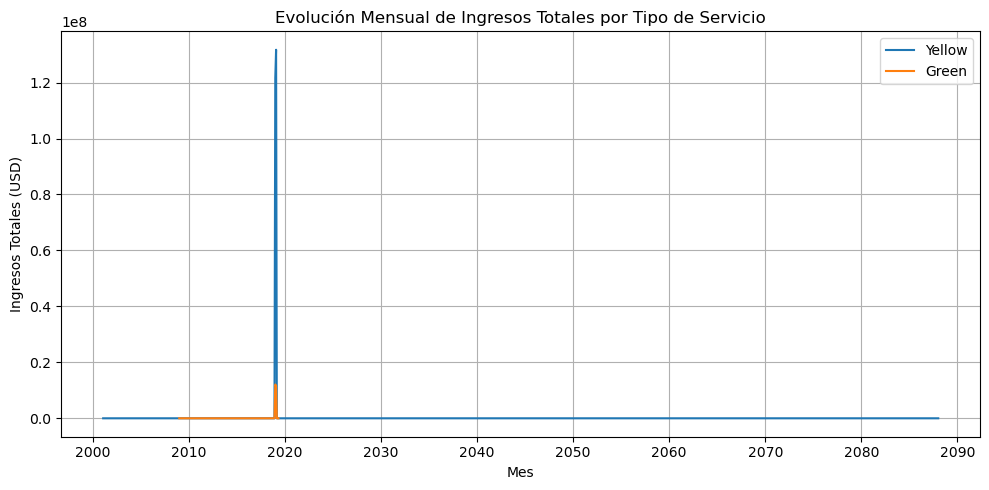

In [20]:
# --- Evolución de ingresos por mes y tipo de servicio ---
plt.figure(figsize=(10,5))
df_month = (
    df_summary.groupby(['trip_month', 'service_type'])['total_revenue']
    .sum()
    .reset_index()
)

for service in df_month['service_type'].unique():
    subset = df_month[df_month['service_type'] == service]
    plt.plot(subset['trip_month'], subset['total_revenue'], label=service.capitalize())

plt.title("Evolución Mensual de Ingresos Totales por Tipo de Servicio")
plt.xlabel("Mes")
plt.ylabel("Ingresos Totales (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


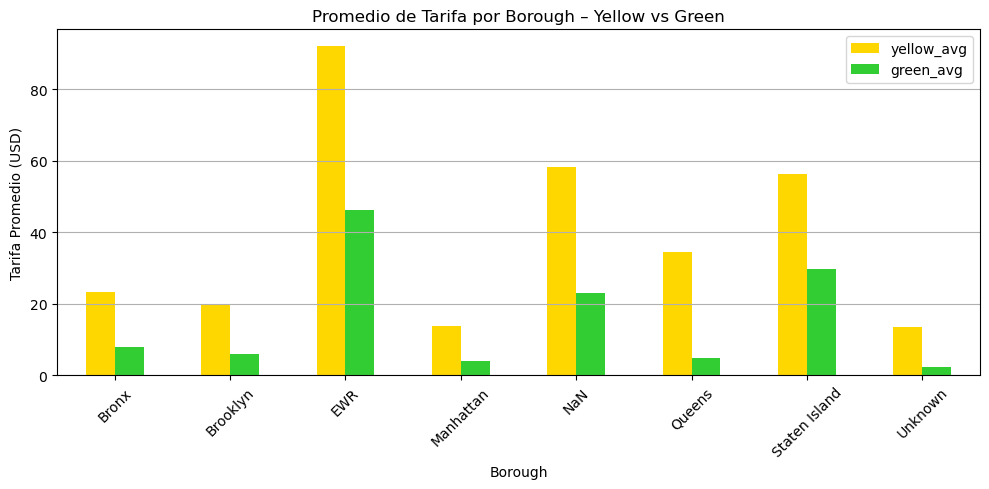

In [21]:
# --- Comparativa de tarifas promedio por borough ---
df_avg = (
    df_comp[['pickup_borough', 'yellow_avg', 'green_avg']]
    .groupby('pickup_borough')
    .mean()
    .reset_index()
)

df_avg.plot(
    x='pickup_borough',
    y=['yellow_avg', 'green_avg'],
    kind='bar',
    figsize=(10,5),
    color=['gold', 'limegreen']
)
plt.title("Promedio de Tarifa por Borough – Yellow vs Green")
plt.xlabel("Borough")
plt.ylabel("Tarifa Promedio (USD)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


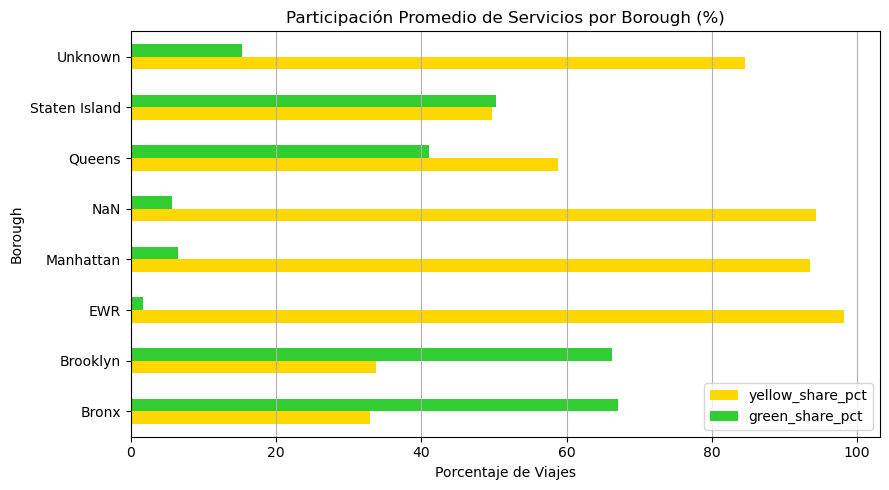

In [22]:
# --- Participación de cada servicio por borough ---
df_share = (
    df_comp[['pickup_borough', 'yellow_share_pct', 'green_share_pct']]
    .groupby('pickup_borough')
    .mean()
    .reset_index()
)

df_share.plot(
    x='pickup_borough',
    y=['yellow_share_pct', 'green_share_pct'],
    kind='barh',
    color=['gold', 'limegreen'],
    figsize=(9,5)
)
plt.title("Participación Promedio de Servicios por Borough (%)")
plt.xlabel("Porcentaje de Viajes")
plt.ylabel("Borough")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


In [24]:
# --- Resumen textual automático ---
avg_diff = (df_comp['fare_diff'].mean()).round(2)
top_borough = (
    df_summary.groupby('pickup_borough')['total_revenue'].sum()
    .idxmax()
)

print("CONCLUSIONES GOLD LAYER:")
print(f"• Diferencia promedio de tarifa entre servicios: ${avg_diff}")
print(f"• Borough con mayor ingreso total: {top_borough}")
print(f"• Ingreso total consolidado (USD): {df_summary['total_revenue'].sum():,.2f}")
print(f"• Total de viajes analizados: {df_summary['trip_count'].sum():,}")


CONCLUSIONES GOLD LAYER:
• Diferencia promedio de tarifa entre servicios: $3.57
• Borough con mayor ingreso total: Manhattan
• Ingreso total consolidado (USD): 277,077,192.72
• Total de viajes analizados: 16,033,615
